### ISSM CA3
Name: Ng Boon Cheong Raymond  
Student ID: A0198543R

In [159]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import pydot
import IPython
import matplotlib.pyplot as plt
%matplotlib inline

import os
import glob
import time
from enum import Enum

from keras.layers import Input, Dense, Concatenate, Flatten
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import plot_model, to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import metrics

### Dataset attributes
Column 1: Timestamp in seconds  
Column 2: Timestamp in microseconds  
Column 3-15: [AccX, AccY, AccZ, GyrX, GyrY, GyrZ, MagX, MagY, MagZ, Q1, Q2, Q3, Q4] of sensor S1 (Left Calf)  
Column 16-28: [AccX, AccY, AccZ, GyrX, GyrY, GyrZ, MagX, MagY, MagZ, Q1, Q2, Q3, Q4] of sensor S2 (Left Thigh)  
Column 29-41: [AccX, AccY, AccZ, GyrX, GyrY, GyrZ, MagX, MagY, MagZ, Q1, Q2, Q3, Q4] of sensor S3 (Right Calf)  
Column 42-54: [AccX, AccY, AccZ, GyrX, GyrY, GyrZ, MagX, MagY, MagZ, Q1, Q2, Q3, Q4] of sensor S4 (Right Thigh)  
Column 55-67: [AccX, AccY, AccZ, GyrX, GyrY, GyrZ, MagX, MagY, MagZ, Q1, Q2, Q3, Q4] of sensor S5 (Back)  
Column 68-80: [AccX, AccY, AccZ, GyrX, GyrY, GyrZ, MagX, MagY, MagZ, Q1, Q2, Q3, Q4] of sensor S6 (Left Lower Arm)  
Column 81-93: [AccX, AccY, AccZ, GyrX, GyrY, GyrZ, MagX, MagY, MagZ, Q1, Q2, Q3, Q4] of sensor S7 (Left Upper Arm)  
Column 94-106: [AccX, AccY, AccZ, GyrX, GyrY, GyrZ, MagX, MagY, MagZ, Q1, Q2, Q3, Q4] of sensor S8 (Right Lower Arm)  
Column 107-119: [AccX, AccY, AccZ, GyrX, GyrY, GyrZ, MagX, MagY, MagZ, Q1, Q2, Q3, Q4] of sensor S9 (Right Upper Arm)  
Column 120: Label (see activity set) [Walking = 1] [Jogging = 2] [Running = 3]

### Dataset Index
| Sensor | AccX | AccY | AccZ | GyrX | GyrY | GyrZ | MagX | MagY | MagZ | Quart1 | Quart2 | Quart3 | Quart4 |  
| S1     | 2    | 3    | 4    | 5    | 6    | 7    | 8    | 9    | 10   | 11     | 12     | 13     | 14     |  
| S2     | 15   | 16   | 17   | 18   | 19   | 20   | 21   | 22   | 23   | 24     | 25     | 26     | 27     |  
| S3     | 28   | 29   | 30   | 31   | 32   | 33   | 34   | 35   | 36   | 37     | 38     | 39     | 40     |    
| S4     | 41   | 42   | 43   | 44   | 45   | 46   | 47   | 48   | 49   | 50     | 51     | 52     | 53     |  
| S5     | 54   | 55   | 56   | 57   | 58   | 59   | 60   | 61   | 62   | 63     | 64     | 65     | 66     |  
| S6     | 67   | 68   | 69   | 70   | 71   | 72   | 73   | 74   | 75   | 76     | 77     | 78     | 79     |  
| S7     | 80   | 81   | 82   | 83   | 84   | 85   | 86   | 87   | 88   | 89     | 90     | 91     | 92     |    
| S8     | 93   | 94   | 95   | 96   | 97   | 98   | 99   | 100  | 101  | 102    | 103    | 104    | 105    |    
| S9     | 106  | 107  | 108  | 109  | 110  | 111  | 112  | 113  | 114  | 115    | 116    | 117    | 118    |   

### Dataset attribute subset to be used
Col[0]: Timestamp in seconds  
Col[1]: Timestamp in microseconds

Col[2-4]: Accel Sensor S1  
Col[15-17]: Accel Sensor S2  
Col[28-30]: Accel Sensor S3  
Col[41-43]: Accel Sensor S4  
Col[54-56]: Accel Sensor S5  
Col[67-69]: Accel Sensor S6  
Col[80-82]: Accel Sensor S7  
Col[93-95]: Accel Sensor S8  
Col[106-108]: Accel Sensor S9  

Col[5-7]: Gyro Sensor S1  
Col[18-20]: Gyro Sensor S2  
Col[31-33]: Gyro Sensor S3  
Col[44-46]: Gyro Sensor S4  
Col[57-59]: Gyro Sensor S5  
Col[70-72]: Gyro Sensor S6  
Col[83-85]: Gyro Sensor S7  
Col[96-98]: Gyro Sensor S8  
Col[109-111]: Gyro Sensor S9  

Col[11-14]: Quart Sensor S1  
Col[24-27]: Quart Sensor S2  
Col[37-40]: Quart Sensor S3  
Col[50-53]: Quart Sensor S4  
Col[63-66]: Quart Sensor S5  
Col[76-79]: Quart Sensor S6  
Col[89-92]: Quart Sensor S7  
Col[102-105]: Quart Sensor S8  
Col[115-118]: Quart Sensor S9  

Col[119]: Activity Label

In [160]:
def readLog(file):
    """Read a single file and return 3 dataframe, for walking, jogging and running"""
    df = pd.read_csv(file, header=None, delim_whitespace=True)
    df_walk = df[df[119] == 1]
    df_jog = df[df[119] == 2]
    df_run = df[df[119] == 3]
    return df_walk, df_jog, df_run

In [161]:
def removeOtherSensor(df_walk, df_jog, df_run):
    # [3:67] S1 to S5
    # [73:76] Mag sensor for S6
    # [80:93] S7
    # [99:102] Mag sensor for S8
    # [106:119] S9
    """Remove all other sensors other than S6 and S8, also removed mag sensors"""
    idx = np.r_[2:67, 73:76, 80:93, 99:102, 106:119]
    return df_walk.drop(df_walk.columns[idx], axis=1), df_jog.drop(df_jog.columns[idx], axis=1), df_run.drop(df_run.columns[idx], axis=1)

In [162]:
def resetIndex(df_walk, df_jog, df_run):
    """Drop the index column created by reset_index()"""
    return df_walk.reset_index().drop('index', axis=1), df_jog.reset_index().drop('index', axis=1), df_run.reset_index().drop('index', axis=1)

In [163]:
def splitSensor(df):
    """Split an activity dataframe into 3 sensor type, accel, gryo and quart"""
    # index for accel sensor for S6 and S8
    idx_accel = [67, 68, 69, 93, 94, 95]
    # index for gryo sensor for S6 and S8
    idx_gyro = [70, 71, 72, 96, 97, 98]
    # index for quart sensor for S6 and S8
    idx_quart = [76, 77, 78, 79, 102, 103, 104, 105]
    return df[idx_accel], df[idx_gyro], df[idx_quart]

In [164]:
def createWindowWithDistance(df, timestep=50, distance=20):
    """Split sensor data into windows of timestep size (timestep (in 0.02 microseconds) : 50 = 1 sec) and overlapped with a distance value"""
    win_stack = []
    for i in range(0, len(df), distance):
        try:
            window = []
            for t in range(timestep):
                window.append(df[i+t])
            win_stack.append(window)
        except:
            continue # Drop any data row which does not fit into the requested time step
    return np.array(win_stack)

In [165]:
def makeDataset():
    """Make a dataset split into walk, jog, run activity with all sensors"""
    dataset_dir = '..\dataset'
    files = glob.glob(dataset_dir + '\*.log')
    dfWalk = []
    dfJog = []
    dfRun = []
    for file in files:
        walk, jog, run = readLog(file)
        dfw, dfj, dfr = removeOtherSensor(walk, jog, run)
        dfw, dfj, dfr = resetIndex(dfw, dfj, dfr)
        dfWalk.append(dfw)
        dfJog.append(dfj)
        dfRun.append(dfr)
    return pd.concat(dfWalk, ignore_index=True), pd.concat(dfJog, ignore_index=True), pd.concat(dfRun, ignore_index=True)

In [166]:
def makeSensorDataSet(df):
    """Make a secondary dataset from a single activity dataset"""
    accel, gyro, quart = splitSensor(df)
    accel, gyro, quart = resetIndex(accel, gyro, quart)
    return accel, gyro, quart

In [167]:
def makeAllSensorWindowedDataSet(accel, gyro, quart, timestep=50, distance=20):
    """Spilt into a windowed dataset. Format = [sample, timestep, features]"""
    stack = []
    for aCol in accel:
        stack.append(createWindowWithDistance(accel[aCol], timestep, distance))
    for gCol in gyro:
        stack.append(createWindowWithDistance(gyro[gCol], timestep, distance))
    for qCol in quart:
        stack.append(createWindowWithDistance(quart[qCol], timestep, distance))
    return np.dstack(stack)    

In [168]:
def makeSingleSensorWindowedDataSet(sensor, timestep=50, distance=20):
    """Spilt into a windowed dataset. Format = [sample, timestep, features]"""
    stack = []
    for col in sensor:
        stack.append(createWindowWithDistance(sensor[col], timestep, distance))
    return np.dstack(stack)

### Alternative Preprocessing

In [169]:
class ActivityType(Enum):
    WALK = 1
    JOG = 2
    RUN = 3

class SensorType(Enum):
    ACCEL = 1
    GYRO = 2
    QUART = 3

In [170]:
def removeMagSensors(df):
    """Remove all mag sensors"""
    idx = np.r_[8:10, 21:23, 34:36, 47:49, 60:62, 73:75, 86:88, 99:101, 112:114]
    return df.drop(df.columns[idx], axis=1)

In [171]:
def removeActivities(df):
    """Remove all activity with label 0"""
    walk = df[df[119] == 1]
    jog = df[df[119] == 2]
    run = df[df[119] == 3]
    return pd.concat([walk, jog, run])

In [172]:
def resetDataIndex(df):
    """Drop the index column created by reset_index()"""
    return df.reset_index().drop('index', axis=1)

In [173]:
def readLogFilesWOMagSensors(directory):
    """Read all log files in directory, return list of subjects dataset"""
    files = glob.glob(dataset_dir + '\*.log')
    dfs = []
    for file in files:
        df = pd.read_csv(file, header=None, delim_whitespace=True)
        df = removeMagSensors(df)
        df = removeActivities(df)
        dfs.append(df)
    all_df = pd.concat(dfs, ignore_index=True)
    return resetDataIndex(all_df)

In [174]:
def splitToSingleSensor(sensortype, df):
    """Split a dataframe into the requested sensor type"""
    idx = []
    if sensortype == SensorType.ACCEL:
        # index for accel sensor for S6 and S8
        idx = np.r_[2:5, 15:18, 28:31, 41:44, 54:57, 67:70, 80:83, 93:96, 106:109]
    elif sensortype == SensorType.GYRO:
        # index for gryo sensor for S6 and S8
        idx = np.r_[5:8, 18:21, 31:34, 44:47, 57:60, 70:73, 83:86, 96:99, 109:112]
    elif sensortype == SensorType.QUART:
        # index for quart sensor for S6 and S8
        idx = np.r_[11:15, 24:28, 37:41, 50:54, 63:67, 76:80, 89:93, 102:106, 115:119]
    return df[idx]

In [175]:
label_dict = {
    0: 'walk',
    1: 'jog',
    2: 'run',   
}

### Inspect single subject dataset

In [176]:
# Read data
data = pd.read_csv('..\dataset\subject1_ideal.log', header=None, delim_whitespace=True)

In [177]:
data = data[data[119]==3]

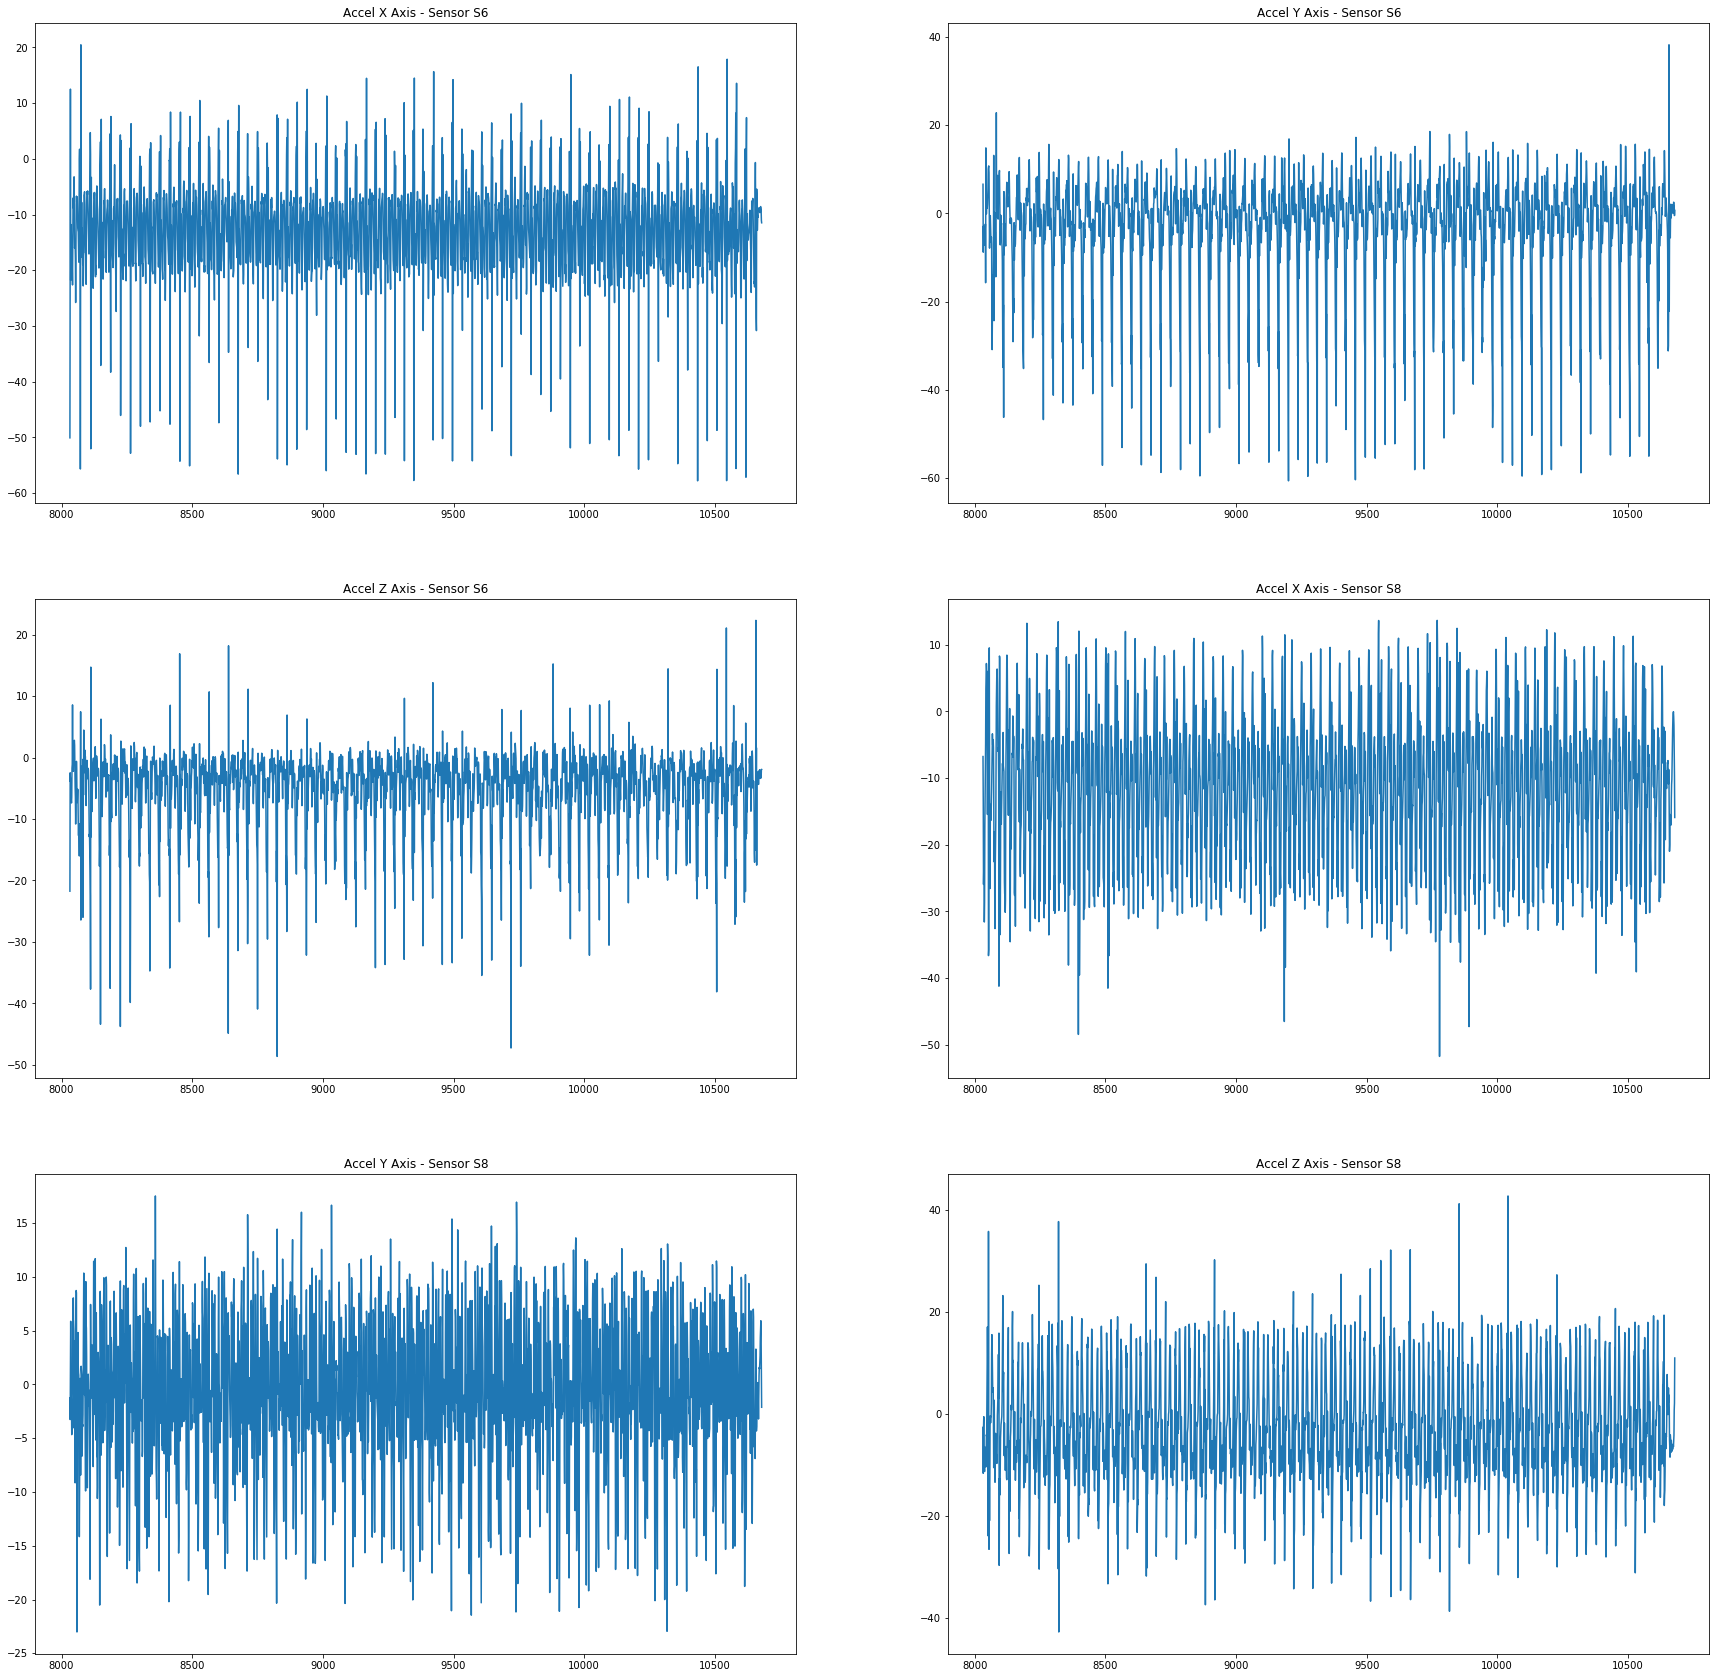

In [178]:
# plot accel data for running activity
plt.figure(figsize=(30,30))
plt.subplot(321)
plt.title('Accel X Axis - Sensor S6')
plt.plot(data[67])
plt.subplot(322)
plt.title('Accel Y Axis - Sensor S6')
plt.plot(data[68])
plt.subplot(323)
plt.title('Accel Z Axis - Sensor S6')
plt.plot(data[69])
plt.subplot(324)
plt.title('Accel X Axis - Sensor S8')
plt.plot(data[93])
plt.subplot(325)
plt.title('Accel Y Axis - Sensor S8')
plt.plot(data[94])
plt.subplot(326)
plt.title('Accel Z Axis - Sensor S8')
plt.plot(data[95])
plt.show()

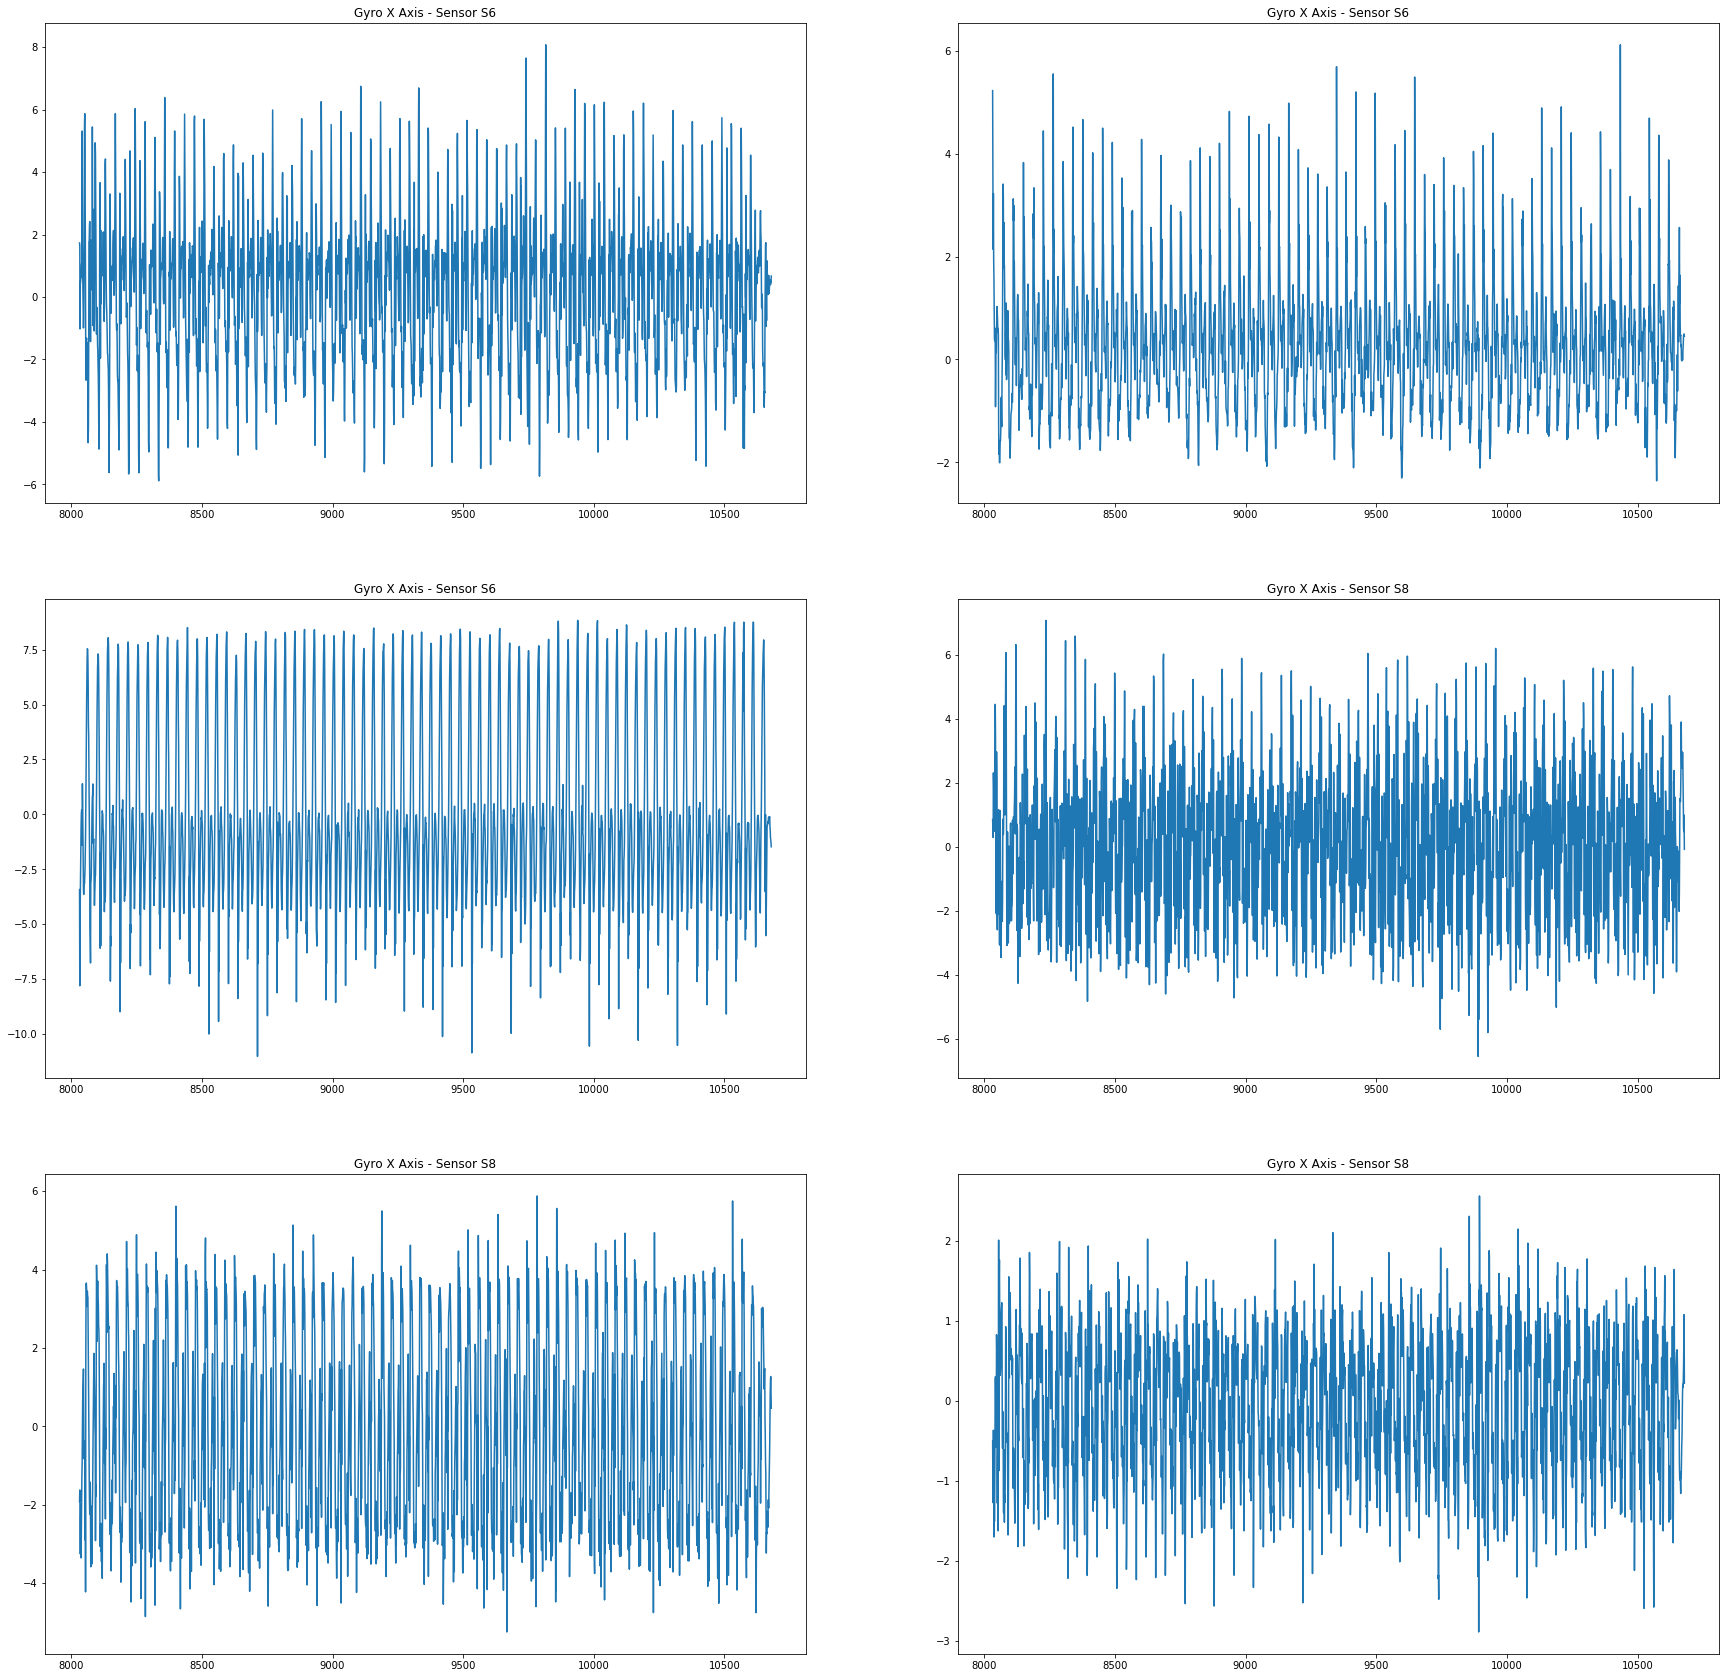

In [179]:
# plot gyro data for running activity
plt.figure(figsize=(30,30))
plt.subplot(321)
plt.title('Gyro X Axis - Sensor S6')
plt.plot(data[70])
plt.subplot(322)
plt.title('Gyro X Axis - Sensor S6')
plt.plot(data[71])
plt.subplot(323)
plt.title('Gyro X Axis - Sensor S6')
plt.plot(data[72])
plt.subplot(324)
plt.title('Gyro X Axis - Sensor S8')
plt.plot(data[96])
plt.subplot(325)
plt.title('Gyro X Axis - Sensor S8')
plt.plot(data[97])
plt.subplot(326)
plt.title('Gyro X Axis - Sensor S8')
plt.plot(data[98])
plt.show()

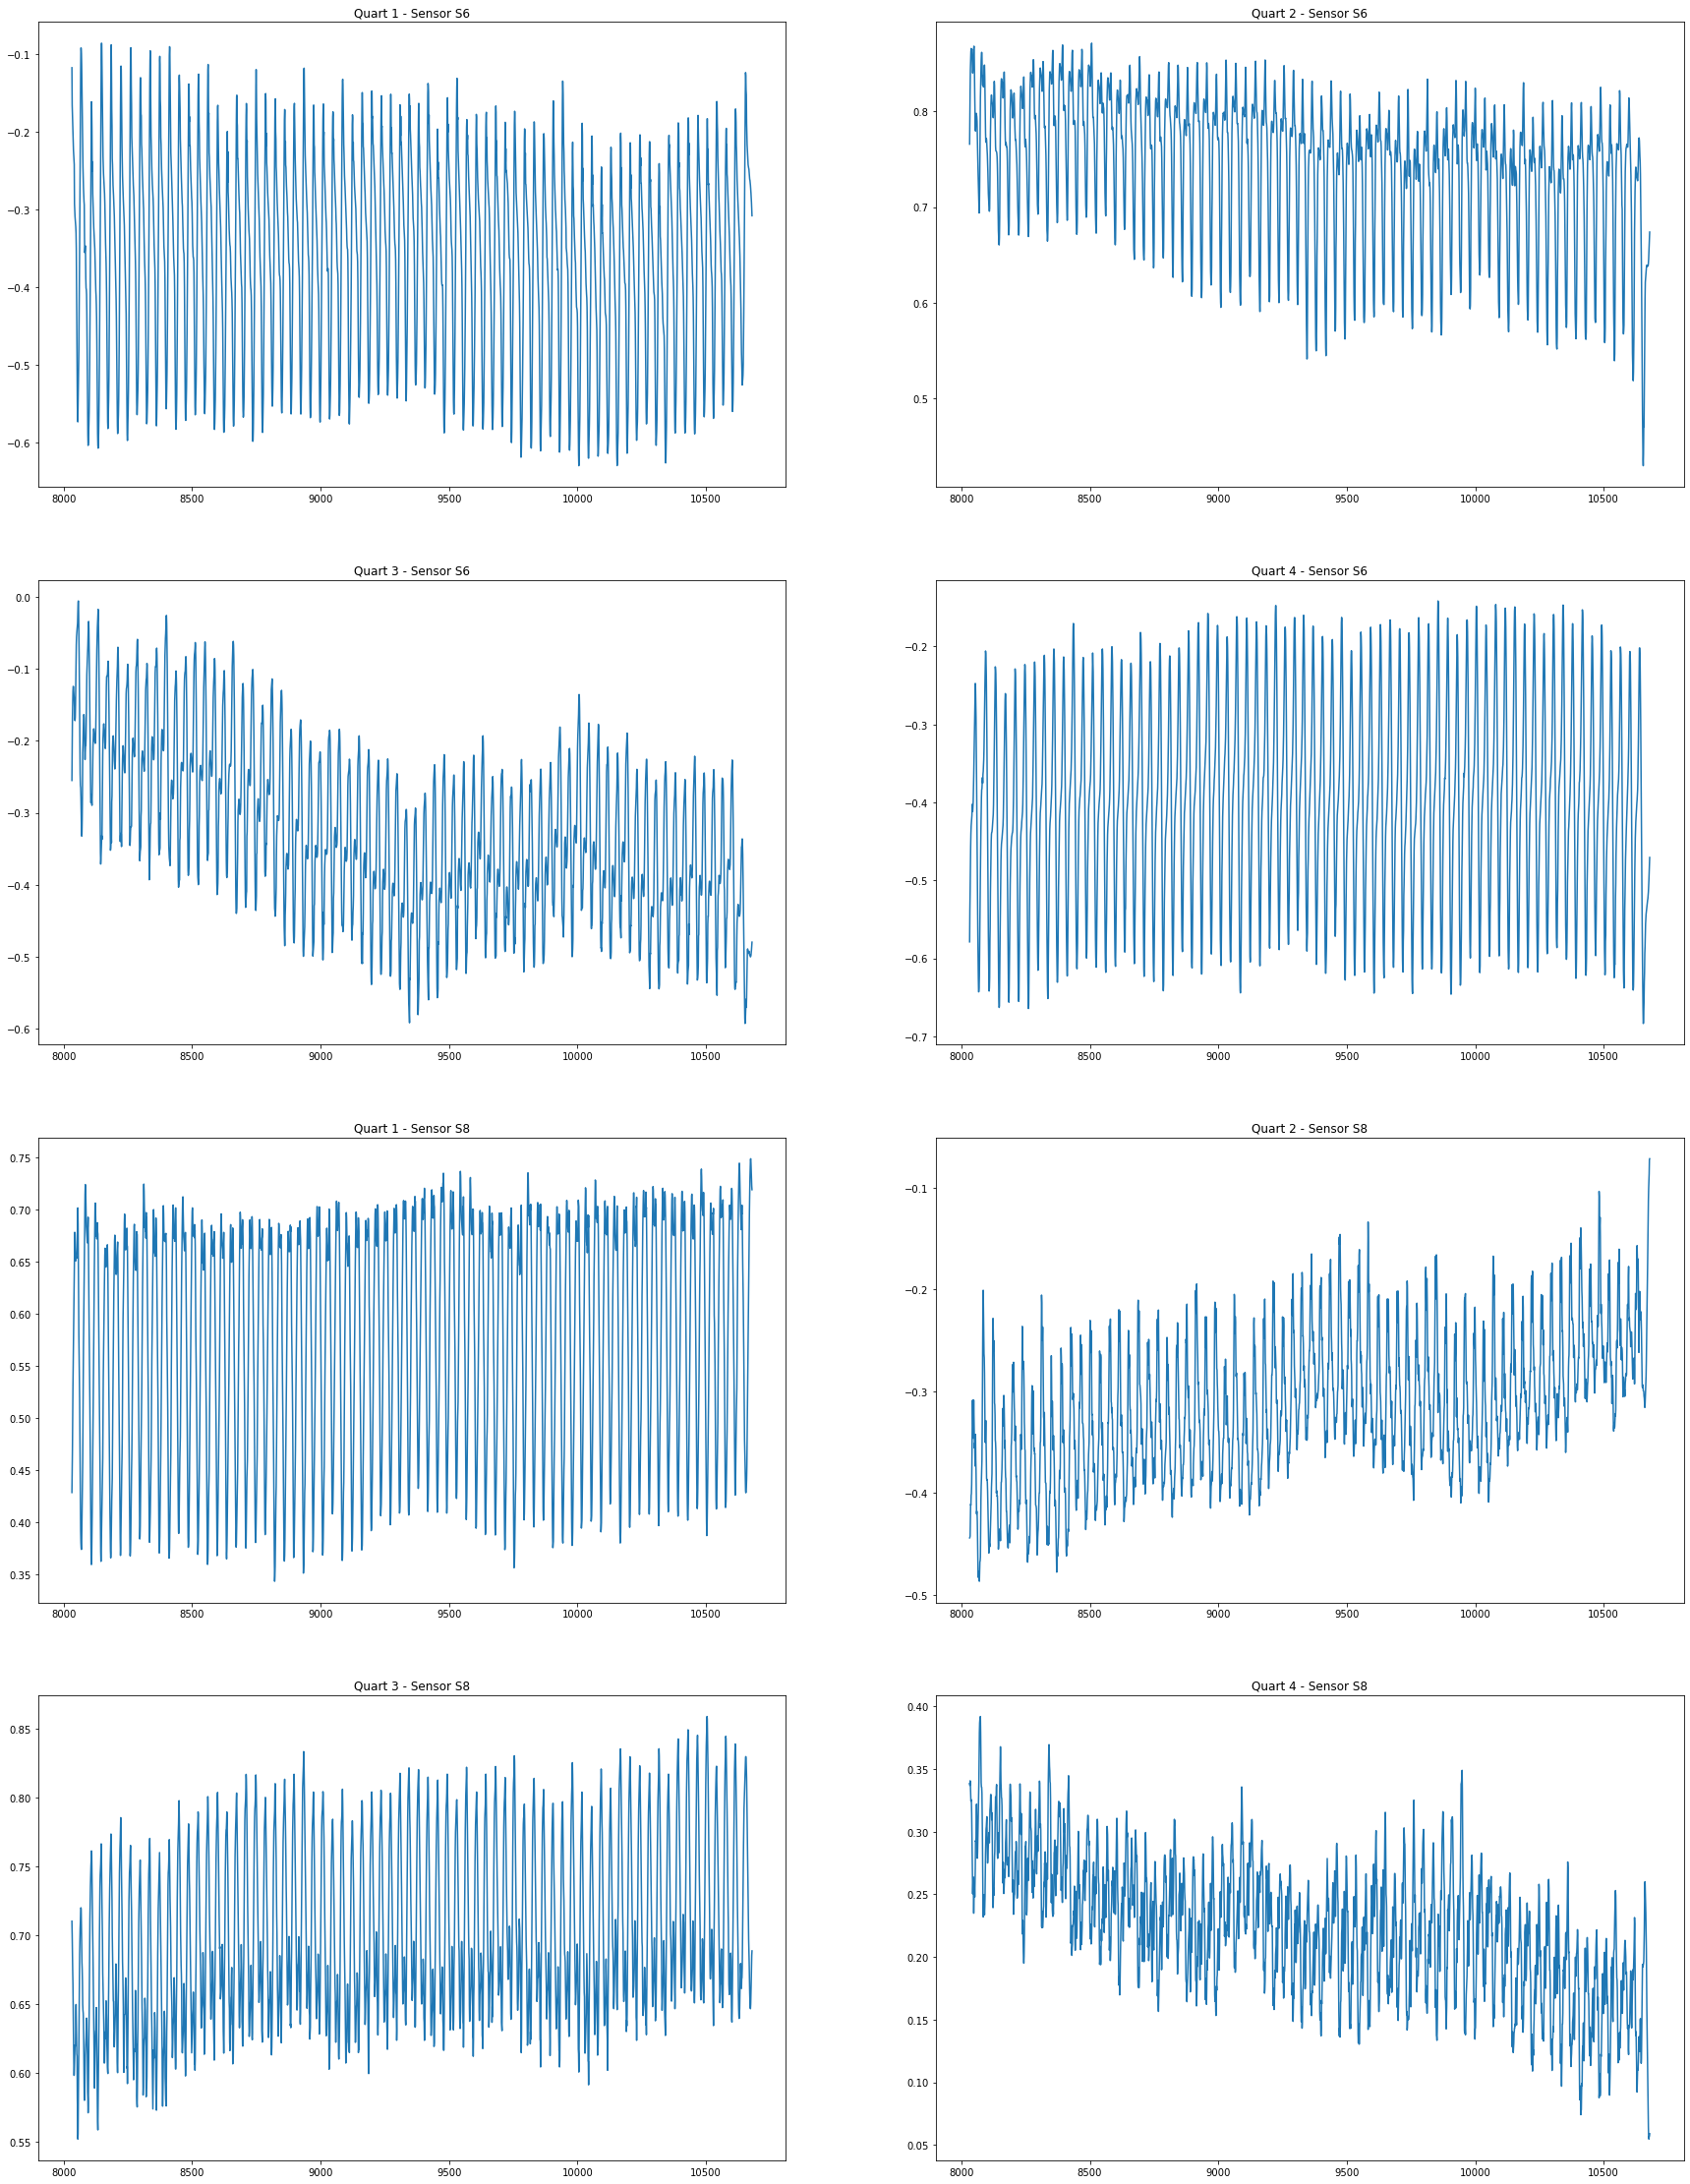

In [180]:
# plot quart data for running activity
plt.figure(figsize=(30,40))
plt.subplot(421)
plt.title('Quart 1 - Sensor S6')
plt.plot(data[76])
plt.subplot(422)
plt.title('Quart 2 - Sensor S6')
plt.plot(data[77])
plt.subplot(423)
plt.title('Quart 3 - Sensor S6')
plt.plot(data[78])
plt.subplot(424)
plt.title('Quart 4 - Sensor S6')
plt.plot(data[79])
plt.subplot(425)
plt.title('Quart 1 - Sensor S8')
plt.plot(data[102])
plt.subplot(426)
plt.title('Quart 2 - Sensor S8')
plt.plot(data[103])
plt.subplot(427)
plt.title('Quart 3 - Sensor S8')
plt.plot(data[104])
plt.subplot(428)
plt.title('Quart 4 - Sensor S8')
plt.plot(data[105])
plt.show()

### Create Accel base sensor dataset

In [181]:
%%time
dataset_dir = '..\dataset'
dfs = readLogFilesWOMagSensors(dataset_dir)
dfs_labels = dfs[119]

Wall time: 50.6 s


In [182]:
dfs.head()

,0,1,2,3,4,5,6,7,10,11,...,108,109,110,111,114,115,116,117,118,119
0,116,740000.0,-11.4970,2.9516,2.2309,0.037920,-0.110540,0.38946,-0.26399,-0.77371,...,0.88089,-2.3970,1.7986,0.69167,0.40753,-0.33477,0.41259,-0.76868,-0.35613,1
1,116,760000.0,-10.0230,2.7700,2.0099,-0.003888,-0.141800,0.53663,-0.26216,-0.77403,...,-6.66300,-1.7635,2.5514,1.14990,0.42753,-0.30361,0.41850,-0.77527,-0.36281,1
2,116,780000.0,-8.6708,2.7707,1.7212,0.069982,-0.119740,0.68120,-0.25931,-0.77399,...,-6.89830,-1.0824,2.4124,1.14510,0.44459,-0.27610,0.42146,-0.78316,-0.36441,1
3,116,800000.0,-8.1259,3.0960,1.4306,0.090034,-0.071039,0.82534,-0.25510,-0.77343,...,-4.34940,-1.2500,1.9504,0.95280,0.45984,-0.25201,0.42442,-0.78777,-0.36849,1
4,116,820000.0,-8.4348,3.3786,1.0930,-0.043007,-0.064941,0.87918,-0.24832,-0.77281,...,0.95296,-2.0334,1.1327,0.23813,0.46286,-0.23351,0.43169,-0.78395,-0.38018,1


In [183]:
accel = splitToSingleSensor(SensorType.ACCEL, dfs)
accel.shape

(143746, 27)

In [184]:
accel.head()

,2,3,4,15,16,17,28,29,30,41,...,69,80,81,82,93,94,95,106,107,108
0,-11.4970,2.9516,2.2309,-11.3010,0.47337,2.52900,-10.2760,0.24500,1.0943,-9.8991,...,0.57370,-10.2590,2.2585,-2.76120,-12.478,3.1355,2.75580,-14.9680,-1.69440,0.88089
1,-10.0230,2.7700,2.0099,-10.0490,0.55811,2.05550,-9.3954,-0.28175,1.0770,-8.6371,...,0.71725,-11.9950,2.7167,-2.28950,-11.441,3.9133,0.34877,-11.0210,0.27247,-6.66300
2,-8.6708,2.7707,1.7212,-8.8858,0.47182,1.65470,-9.3050,-0.73750,1.3793,-7.8587,...,0.85967,-11.7230,3.0999,-1.42220,-10.751,3.6325,-1.89120,-10.6910,-1.06800,-6.89830
3,-8.1259,3.0960,1.4306,-8.1736,0.32108,1.05020,-9.4604,-1.08770,1.4235,-7.7354,...,0.77778,-9.8341,3.2033,-0.57505,-10.767,3.0954,-4.17700,-10.5590,0.57260,-4.34940
4,-8.4348,3.3786,1.0930,-8.4060,0.16542,0.79453,-9.7145,-1.14540,1.3003,-8.2719,...,1.21080,-9.3814,2.0499,-0.34853,-11.331,2.1859,-3.92610,-9.2047,-1.80250,0.95296


### Apply standardscaler to dataset

In [185]:
accelS = np.array(StandardScaler().fit_transform(accel))
accelS.shape

(143746, 27)

### Split to train and test set

In [186]:
train_size = int(len(accelS)*0.8)
accelS_train, accelS_test = accelS[:train_size], accelS[train_size:]
accelS_train_label, accelS_test_label = dfs_labels[:train_size], dfs_labels[train_size:]
print(f'accelS_train: {accelS_train.shape}, accelS_test: {accelS_test.shape}')
print(f'accelS_train_label: {accelS_train_label.shape}, accelS_test_label: {accelS_test_label.shape}')

accelS_train: (114996, 27), accelS_test: (28750, 27)
accelS_train_label: (114996,), accelS_test_label: (28750,)


In [187]:
acc_train_X, acc_val_X, acc_train_Ground, acc_val_Ground = train_test_split(accelS_train, accelS_train, test_size=0.2, random_state=42)
print(f'Train X Accel: {acc_train_X.shape}, Val X Accel: {acc_val_X.shape}')
print(f'Train Ground Accel: {acc_train_Ground.shape}, Val Ground Accel: {acc_val_Ground.shape}')

Train X Accel: (91996, 27), Val X Accel: (23000, 27)
Train Ground Accel: (91996, 27), Val Ground Accel: (23000, 27)


In [188]:
seed = 42
np.random.seed(seed)

In [189]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
    EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)
]

### Base Model (Accel)

In [190]:
# Config
EPOCH = 100
BATCH_SIZE = 24
ACCEL_INPUT = Input(shape=(acc_train_X.shape[1],), name='Input_Accel')

In [191]:
# modelname = 'base_accel_model'
def build_base_encoder_model(input_accel):
    encoder = Dense(27, activation='relu', name='Encoder1')(input_accel)
    encoder = Dense(15, activation='relu', name='Encoder2')(encoder)
    encoder = Dense(3, activation='relu', name='Encoder3')(encoder)
    return encoder

In [192]:
def build_base_decoder_model(encoder):
    decoder = Dense(15, activation='relu', name='Decoder1')(encoder)
    decoder = Dense(27, activation='relu', name='Decoder2')(decoder)
    return decoder

In [193]:
autoencoder = Model(ACCEL_INPUT, build_base_decoder_model(build_base_encoder_model(ACCEL_INPUT)))
autoencoder.compile(optimizer='adam', metrics=['accuracy'], loss=['mean_squared_error'])
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Accel (InputLayer)     (None, 27)                0         
_________________________________________________________________
Encoder1 (Dense)             (None, 27)                756       
_________________________________________________________________
Encoder2 (Dense)             (None, 15)                420       
_________________________________________________________________
Encoder3 (Dense)             (None, 3)                 48        
_________________________________________________________________
Decoder1 (Dense)             (None, 15)                60        
_________________________________________________________________
Decoder2 (Dense)             (None, 27)                432       
Total params: 1,716
Trainable params: 1,716
Non-trainable params: 0
_________________________________________________________________


In [194]:
%%time
history = autoencoder.fit(acc_train_X, acc_train_Ground, 
                    validation_split=0.1, epochs=EPOCH, batch_size=BATCH_SIZE, callbacks=callbacks, validation_data=(acc_val_X, acc_val_Ground))

Train on 91996 samples, validate on 23000 samples
Epoch 1/100
91996/91996 [==============================] - 33s 363us/step - loss: 0.7937 - acc: 0.2629 - val_loss: 0.7391 - val_acc: 0.3345
Epoch 2/100
91996/91996 [==============================] - 33s 355us/step - loss: 0.7382 - acc: 0.3471 - val_loss: 0.7290 - val_acc: 0.3517
Epoch 3/100
91996/91996 [==============================] - 33s 358us/step - loss: 0.7319 - acc: 0.3604 - val_loss: 0.7248 - val_acc: 0.3632
Epoch 4/100
91996/91996 [==============================] - 32s 351us/step - loss: 0.7271 - acc: 0.3680 - val_loss: 0.7165 - val_acc: 0.3745
Epoch 5/100
91996/91996 [==============================] - 33s 355us/step - loss: 0.7200 - acc: 0.3798 - val_loss: 0.7127 - val_acc: 0.3815
Epoch 6/100
91996/91996 [==============================] - 33s 354us/step - loss: 0.7171 - acc: 0.3855 - val_loss: 0.7105 - val_acc: 0.3888
Epoch 7/100
91996/91996 [==============================] - 35s 377us/step - loss: 0.7156 - acc: 0.3902 - val_l

### Plot metrics

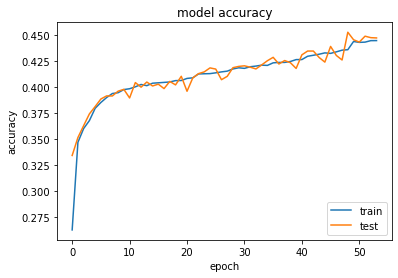

In [195]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

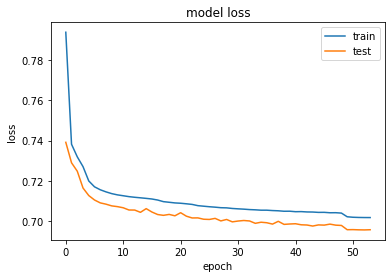

In [196]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Prepare test labels

In [197]:
accTrainLabel = np.array(accelS_train_label).reshape(-1, 1)
accTestLabel = np.array(accelS_test_label).reshape(-1, 1)
acc_train_Y_OH = OneHotEncoder().fit_transform(accTrainLabel)
acc_test_Y_OH = OneHotEncoder().fit_transform(accTestLabel)
print(f'Train Y: {acc_train_Y_OH.shape}, Test Y: {acc_test_Y_OH.shape}')

Train Y: (114996, 3), Test Y: (28750, 3)


In [198]:
acc_train_clsX, acc_val_clsX, acc_train_label, acc_val_label = train_test_split(accelS_train, acc_train_Y_OH, test_size=0.2, random_state=42)

### Accel Classification Model

In [199]:
def build_classify_encoder_model(input_accel):
    encoder = Dense(27, activation='relu', name='Encoder1')(input_accel)
    encoder = Dense(15, activation='relu', name='Encoder2')(encoder)
    encoder = Dense(3, activation='relu', name='Encoder3')(encoder)
    return encoder

def fc(encoder):
#     flat = Flatten()(encoder)
    dense = Dense(27, activation='relu')(encoder)
    out = Dense(3, activation='softmax')(dense)
    return out

In [200]:
encoder = build_classify_encoder_model(ACCEL_INPUT)
full_model = Model(ACCEL_INPUT, fc(encoder))
full_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Accel (InputLayer)     (None, 27)                0         
_________________________________________________________________
Encoder1 (Dense)             (None, 27)                756       
_________________________________________________________________
Encoder2 (Dense)             (None, 15)                420       
_________________________________________________________________
Encoder3 (Dense)             (None, 3)                 48        
_________________________________________________________________
dense_11 (Dense)             (None, 27)                108       
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 84        
Total params: 1,416
Trainable params: 1,416
Non-trainable params: 0
_________________________________________________________________


### Transfer weight to accel classification model

In [201]:
for l1, l2 in zip(full_model.layers[:4], autoencoder.layers[0:4]):
    l1.set_weights(l2.get_weights())

In [202]:
autoencoder.get_weights()[0][1]

array([ 0.19081382,  0.03209838, -0.28557158,  0.0630356 , -0.25830492,
        0.6237635 , -0.02644752,  0.12000062,  0.06071622, -0.23754553,
       -0.00706653, -0.10702578,  0.20027263, -0.08238685, -0.07104491,
       -0.00316635, -0.09172294, -0.07696749,  0.07503431,  0.12515266,
       -0.1611142 ,  0.29324102,  0.03592941,  0.6442381 , -0.00367577,
       -0.40852657,  0.41747504], dtype=float32)

In [203]:
full_model.get_weights()[0][1]

array([ 0.19081382,  0.03209838, -0.28557158,  0.0630356 , -0.25830492,
        0.6237635 , -0.02644752,  0.12000062,  0.06071622, -0.23754553,
       -0.00706653, -0.10702578,  0.20027263, -0.08238685, -0.07104491,
       -0.00316635, -0.09172294, -0.07696749,  0.07503431,  0.12515266,
       -0.1611142 ,  0.29324102,  0.03592941,  0.6442381 , -0.00367577,
       -0.40852657,  0.41747504], dtype=float32)

In [204]:
full_model.compile(loss=['categorical_crossentropy'], optimizer='adam', metrics=['accuracy'])

In [205]:
class_train = full_model.fit(acc_train_clsX, acc_train_label, epochs=EPOCH, batch_size=BATCH_SIZE, shuffle=True, callbacks=callbacks,validation_data=(acc_val_clsX, acc_val_label))

Train on 91996 samples, validate on 23000 samples
Epoch 1/100
91996/91996 [==============================] - 40s 432us/step - loss: 0.3009 - acc: 0.8672 - val_loss: 0.2065 - val_acc: 0.9175
Epoch 2/100
91996/91996 [==============================] - 35s 385us/step - loss: 0.1863 - acc: 0.9281 - val_loss: 0.1662 - val_acc: 0.9377
Epoch 3/100
91996/91996 [==============================] - 38s 410us/step - loss: 0.1590 - acc: 0.9410 - val_loss: 0.1602 - val_acc: 0.9401
Epoch 4/100
91996/91996 [==============================] - 20s 222us/step - loss: 0.1448 - acc: 0.9473 - val_loss: 0.1397 - val_acc: 0.9485
Epoch 5/100
91996/91996 [==============================] - 21s 230us/step - loss: 0.1361 - acc: 0.9505 - val_loss: 0.1372 - val_acc: 0.9500
Epoch 6/100
91996/91996 [==============================] - 21s 223us/step - loss: 0.1281 - acc: 0.9538 - val_loss: 0.1321 - val_acc: 0.9518
Epoch 7/100
91996/91996 [==============================] - 21s 223us/step - loss: 0.1225 - acc: 0.9557 - val_l

In [206]:
full_model.save_weights('accel_base_class_complete.h5')

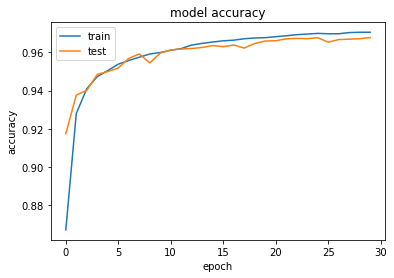

In [207]:
# summarize history for accuracy
plt.plot(class_train.history['acc'])
plt.plot(class_train.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

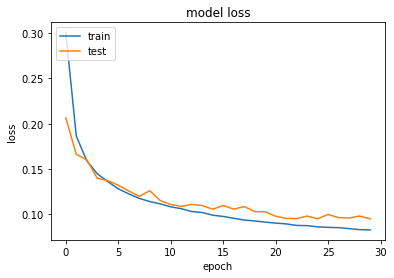

In [208]:
# summarize history for loss
plt.plot(class_train.history['loss'])
plt.plot(class_train.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [209]:
acc_test_eval = full_model.evaluate(accelS_test, acc_test_Y_OH)
print(f'Accel Base Test Loss: {acc_test_eval[0]}')
print(f'Accel Base Test Accuracy: {acc_test_eval[1]}')

28750/28750 [==============================] - 1s 46us/step
Accel Base Test Loss: 0.46356420732077375
Accel Base Test Accuracy: 0.8538086956438811


### Create Gyro sensor dataset

In [210]:
gyro = splitToSingleSensor(SensorType.GYRO, dfs)
gyro.shape

(143746, 27)

In [211]:
gyro.head()

,5,6,7,18,19,20,31,32,33,44,...,72,83,84,85,96,97,98,109,110,111
0,0.037920,-0.110540,0.38946,-0.177900,0.134510,0.27822,-0.46793,0.252810,-0.093065,-0.13288,...,0.52799,0.984430,2.01590,0.362460,-0.38356,-2.0240,0.186220,-2.3970,1.7986,0.69167
1,-0.003888,-0.141800,0.53663,-0.122320,0.045556,0.18674,-0.47638,0.310420,-0.080098,-0.26584,...,0.43636,0.660460,1.82650,0.264880,-0.74745,-2.2296,0.210120,-1.7635,2.5514,1.14990
2,0.069982,-0.119740,0.68120,-0.084771,-0.091129,0.11522,-0.44804,0.279710,-0.085808,-0.42252,...,0.34575,0.099562,1.36040,0.142630,-1.31200,-2.2390,0.029446,-1.0824,2.4124,1.14510
3,0.090034,-0.071039,0.82534,-0.089449,-0.136760,0.11555,-0.33216,0.165650,-0.099488,-0.61423,...,0.35471,-0.570590,1.07950,0.042627,-1.77930,-2.1165,-0.266440,-1.2500,1.9504,0.95280
4,-0.043007,-0.064941,0.87918,-0.123990,-0.173620,0.16252,-0.17856,0.013982,-0.099001,-0.90926,...,0.37671,-0.894930,0.92305,0.004886,-2.07790,-1.6963,-0.509020,-2.0334,1.1327,0.23813


### Apply standardscaler to dataset

In [212]:
gyroS = np.array(StandardScaler().fit_transform(gyro))
gyroS.shape

(143746, 27)

In [213]:
gtrain_size = int(len(gyroS)*0.8)
gyroS_train, gyroS_test = gyroS[:gtrain_size], gyro[gtrain_size:]
gyroS_train_label, gyroS_test_label = dfs_labels[:gtrain_size], dfs_labels[gtrain_size:]
print(f'gyroS_train: {gyroS_train.shape}, gyroS_test: {gyroS_test.shape}')
print(f'gyroS_train_label: {gyroS_train_label.shape}, gyroS_test_label: {gyroS_test_label.shape}')

gyroS_train: (114996, 27), gyroS_test: (28750, 27)
gyroS_train_label: (114996,), gyroS_test_label: (28750,)


In [214]:
gyr_train_X, gyr_val_X, acc_train_Ground, acc_val_Ground = train_test_split(gyroS_train, accelS_train, test_size=0.2, random_state=42)
print(f'Train X Gyro: {gyr_train_X.shape}, Val X Gyro: {gyr_val_X.shape}')
print(f'Train Ground Accel: {acc_train_Ground.shape}, Val Ground Accel: {acc_val_Ground.shape}')

Train X Gyro: (91996, 27), Val X Gyro: (23000, 27)
Train Ground Accel: (91996, 27), Val Ground Accel: (23000, 27)


### Gyro -> Accel Model

In [215]:
EPOCH = 100
BATCH_SIZE = 24
GYRO_INPUT = Input(shape=(gyr_train_X.shape[1],), name='Input_Gyro')

In [216]:
def build_gyro_encoder_model(input_gyro):
    encoder = Dense(27, activation='relu', name='Encoder1')(input_gyro)
    encoder = Dense(15, activation='relu', name='Encoder2')(encoder)
    encoder = Dense(3, activation='relu', name='Encoder3')(encoder)
    return encoder

In [217]:
def build_gyro_decoder_model(encoder):
    decoder = Dense(15, activation='relu', name='Decoder1')(encoder)
    decoder = Dense(27, activation='relu', name='Decoder2')(decoder)
    return decoder

In [218]:
gautoencoder = Model(GYRO_INPUT, build_gyro_decoder_model(build_gyro_encoder_model(GYRO_INPUT)))
gautoencoder.compile(optimizer='adam', metrics=['accuracy'], loss=['mean_squared_error'])
gautoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Gyro (InputLayer)      (None, 27)                0         
_________________________________________________________________
Encoder1 (Dense)             (None, 27)                756       
_________________________________________________________________
Encoder2 (Dense)             (None, 15)                420       
_________________________________________________________________
Encoder3 (Dense)             (None, 3)                 48        
_________________________________________________________________
Decoder1 (Dense)             (None, 15)                60        
_________________________________________________________________
Decoder2 (Dense)             (None, 27)                432       
Total params: 1,716
Trainable params: 1,716
Non-trainable params: 0
_________________________________________________________________


In [219]:
%%time
ghistory = gautoencoder.fit(gyr_train_X, acc_train_Ground,
                           validation_split=0.1, epochs=EPOCH, batch_size=BATCH_SIZE, callbacks=callbacks, validation_data=(gyr_val_X, acc_val_Ground))

Train on 91996 samples, validate on 23000 samples
Epoch 1/100
91996/91996 [==============================] - 17s 188us/step - loss: 0.8769 - acc: 0.1141 - val_loss: 0.8301 - val_acc: 0.1318
Epoch 2/100
91996/91996 [==============================] - 18s 192us/step - loss: 0.8235 - acc: 0.1679 - val_loss: 0.7969 - val_acc: 0.2073
Epoch 3/100
91996/91996 [==============================] - 18s 192us/step - loss: 0.7945 - acc: 0.2112 - val_loss: 0.7829 - val_acc: 0.2269
Epoch 4/100
91996/91996 [==============================] - 18s 193us/step - loss: 0.7843 - acc: 0.2413 - val_loss: 0.7757 - val_acc: 0.2493
Epoch 5/100
91996/91996 [==============================] - 17s 183us/step - loss: 0.7794 - acc: 0.2514 - val_loss: 0.7726 - val_acc: 0.2618
Epoch 6/100
91996/91996 [==============================] - 17s 186us/step - loss: 0.7761 - acc: 0.2576 - val_loss: 0.7695 - val_acc: 0.2701
Epoch 7/100
91996/91996 [==============================] - 17s 189us/step - loss: 0.7735 - acc: 0.2626 - val_l

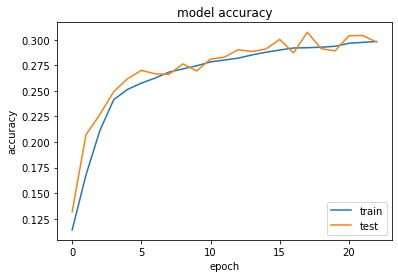

In [220]:
# summarize history for accuracy
plt.plot(ghistory.history['acc'])
plt.plot(ghistory.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

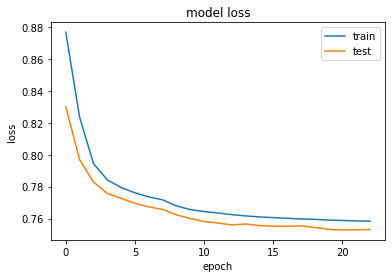

In [221]:
# summarize history for loss
plt.plot(ghistory.history['loss'])
plt.plot(ghistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Prepare test labels

In [222]:
gyrTrainLabel = np.array(gyroS_train_label).reshape(-1,1)
gyrTestLabel = np.array(gyroS_test_label).reshape(-1,1)
gyr_train_Y_OH = OneHotEncoder().fit_transform(gyrTrainLabel)
gyr_test_Y_OH = OneHotEncoder().fit_transform(gyrTestLabel)
print(f'gTrain Y: {gyr_train_Y_OH.shape}, gTest Y: {gyr_test_Y_OH.shape}')

gTrain Y: (114996, 3), gTest Y: (28750, 3)


In [223]:
gyr_train_clsX, gyr_val_clsX, gyr_train_label, gyr_val_label = train_test_split(gyroS_train, gyr_train_Y_OH, test_size=0.2, random_state=42)

### Gyro Classification Model

In [224]:
def build_classify_encoder_gmodel(input_gyro):
    encoder = Dense(27, activation='relu', name='Encoder1')(input_gyro)
    encoder = Dense(15, activation='relu', name='Encoder2')(encoder)
    encoder = Dense(3, activation='relu', name='Encoder3')(encoder)
    return encoder

def gfc(encoder):
#     flat = Flatten()(encoder)
    dense = Dense(27, activation='relu')(encoder)
    out = Dense(3, activation='softmax')(dense)
    return out

In [225]:
gencoder = build_classify_encoder_gmodel(GYRO_INPUT)
full_gmodel = Model(GYRO_INPUT, gfc(gencoder))
full_gmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Gyro (InputLayer)      (None, 27)                0         
_________________________________________________________________
Encoder1 (Dense)             (None, 27)                756       
_________________________________________________________________
Encoder2 (Dense)             (None, 15)                420       
_________________________________________________________________
Encoder3 (Dense)             (None, 3)                 48        
_________________________________________________________________
dense_13 (Dense)             (None, 27)                108       
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 84        
Total params: 1,416
Trainable params: 1,416
Non-trainable params: 0
_________________________________________________________________


### Transfer weight to gyro classification model

In [226]:
for l1, l2 in zip(full_gmodel.layers[:4], gautoencoder.layers[0:4]):
    l1.set_weights(l2.get_weights())

In [227]:
gautoencoder.get_weights()[0][1]

array([-0.13658963,  0.25584984, -0.02635567,  0.05881017, -0.18980671,
       -0.21404837,  0.22984543, -0.18529253, -0.16042107, -0.24709359,
       -0.01418698,  0.22778913, -0.08368507,  0.06506468,  0.18447314,
       -0.28145668, -0.04012523, -0.0676701 , -0.09772844, -0.54244334,
        0.44070458, -0.15074937, -0.23427927, -0.14361921,  0.08351569,
       -0.1106995 ,  0.2598634 ], dtype=float32)

In [228]:
full_gmodel.get_weights()[0][1]

array([-0.13658963,  0.25584984, -0.02635567,  0.05881017, -0.18980671,
       -0.21404837,  0.22984543, -0.18529253, -0.16042107, -0.24709359,
       -0.01418698,  0.22778913, -0.08368507,  0.06506468,  0.18447314,
       -0.28145668, -0.04012523, -0.0676701 , -0.09772844, -0.54244334,
        0.44070458, -0.15074937, -0.23427927, -0.14361921,  0.08351569,
       -0.1106995 ,  0.2598634 ], dtype=float32)

In [229]:
full_gmodel.compile(loss=['categorical_crossentropy'], optimizer='adam', metrics=['accuracy'])

In [ ]:
gclass_train = full_gmodel.fit(gyr_train_clsX, gyr_train_label, epochs=EPOCH, batch_size=BATCH_SIZE, shuffle=True, callbacks=callbacks, validation_data=(gyr_val_clsX, gyr_val_label))

Train on 91996 samples, validate on 23000 samples
Epoch 1/100
91996/91996 [==============================] - 20s 213us/step - loss: 0.2739 - acc: 0.8861 - val_loss: 0.1598 - val_acc: 0.9377
Epoch 2/100
91996/91996 [==============================] - 19s 207us/step - loss: 0.1407 - acc: 0.9453 - val_loss: 0.1338 - val_acc: 0.9480
Epoch 3/100
91996/91996 [==============================] - 20s 214us/step - loss: 0.1221 - acc: 0.9527 - val_loss: 0.1228 - val_acc: 0.9540
Epoch 4/100
91996/91996 [==============================] - 19s 205us/step - loss: 0.1122 - acc: 0.9578 - val_loss: 0.1135 - val_acc: 0.9579
Epoch 5/100
91996/91996 [==============================] - 19s 203us/step - loss: 0.1065 - acc: 0.9605 - val_loss: 0.1024 - val_acc: 0.9621
Epoch 6/100
91996/91996 [==============================] - 19s 205us/step - loss: 0.1018 - acc: 0.9622 - val_loss: 0.1062 - val_acc: 0.9600
Epoch 7/100
91996/91996 [==============================] - 19s 206us/step - loss: 0.0974 - acc: 0.9641 - val_l

In [ ]:
full_gmodel.save_weights('gyro_accel_class_complete.h5')

In [ ]:
# summarize history for accuracy
plt.plot(gclass_train.history['acc'])
plt.plot(gclass_train.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(gclass_train.history['loss'])
plt.plot(gclass_train.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
gyr_test_eval = full_model.evaluate(gyroS_test, gyr_test_Y_OH)
print(f'Gyro Accel Test Loss: {gyr_test_eval[0]}')
print(f'Gyro Accel Test Accuracy: {gyr_test_eval[1]}')